In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

from torchvision import transforms, models

In [23]:
torch.manual_seed(999999999)
import warnings
warnings.filterwarnings("ignore")

In [24]:
# Preprocessing pipeline for the images
transform = transforms.Compose([
    transforms.ToPILImage(),            # numpy -> PIL Image
    transforms.Resize((224, 224)),      # resize to ResNet18 expected input size
    transforms.RandomHorizontalFlip(),  # simple augmentation
    transforms.ToTensor(),              # [0,255] -> [0,1] and HWC -> CHW
    transforms.Normalize(               # ImageNet mean/std
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [25]:
class H5TrainSubset(Dataset):
    """
    Dataset built from train_catvnoncat.h5 only.
    Uses subset of indices for training or testing.
    """
    def __init__(self, h5_path, x_key="train_set_x", y_key="train_set_y",
                 indices=None, transform=None):
        super().__init__()
        self.file_path = h5_path
        self.x_key = x_key
        self.y_key = y_key
        self.transform = transform

        # Load the full training set once into memory
        with h5py.File(self.file_path, "r") as f:
            X = f[self.x_key][:]   # shape: (209, 64, 64, 3)
            y = f[self.y_key][:]   # shape: (209,)

        self.X_full = X
        self.y_full = y.astype(np.float32)

        if indices is None:
            self.indices = np.arange(len(self.y_full))
        else:
            self.indices = np.array(indices)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # idx is the index in this subset
        orig_idx = self.indices[idx]        # index in original train_set_x
        img = self.X_full[orig_idx]         # (64,64,3), uint8
        label = self.y_full[orig_idx]       # scalar 0 or 1

        if self.transform is not None:
            img = self.transform(img)

        label = torch.tensor(label, dtype=torch.float32)
        return img, label, orig_idx          # return original index for reporting

In [26]:
# Total number of training samples in train_catvnoncat.h5
total_train = 209

# Change this to the LAST digit of your SB (student) ID
last_digit = 7

# Requirement interpretation:
#   New training set has (160 + last_digit) images
#   taken from the *front* of the original training set:
#   indices 0 .. (160 + last_digit - 1)
new_train_size = 160 + last_digit

if new_train_size > total_train:
    raise ValueError(f"160 + last_digit = {new_train_size} exceeds total_train = {total_train}")

new_train_indices = list(range(new_train_size))          # 0 .. new_train_size-1
new_test_indices  = list(range(new_train_size, total_train))  # remaining indices

print("New training set size:", len(new_train_indices))   # should be 160 + last_digit
print("New test set size:", len(new_test_indices))        # should be 209 - (160 + last_digit)
print("First few train indices:", new_train_indices[:10])
print("First few test indices:", new_test_indices[:10])

New training set size: 167
New test set size: 42
First few train indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
First few test indices: [167, 168, 169, 170, 171, 172, 173, 174, 175, 176]


In [27]:
train_dataset = H5TrainSubset(
    h5_path="train_catvnoncat.h5",
    x_key="train_set_x",
    y_key="train_set_y",
    indices=new_train_indices,
    transform=transform
)

test_dataset = H5TrainSubset(
    h5_path="train_catvnoncat.h5",
    x_key="train_set_x",
    y_key="train_set_y",
    indices=new_test_indices,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False)

print("Train loader size:", len(train_dataset))
print("Test loader size:", len(test_dataset))

Train loader size: 167
Test loader size: 42


In [28]:
def create_model():
    # Pretrained ResNet18 from torchvision
    model = models.resnet18(pretrained=True)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 1)  # single logit for binary classification
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = create_model().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Using device: cpu


In [29]:
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    running_loss = 0.0

    for images, labels, _ in loader:
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)  # shape (B, 1)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    return running_loss / len(loader.dataset)


num_epochs = 2
train_losses = []

for epoch in range(num_epochs):
    epoch_loss = train_one_epoch(model, train_loader, optimizer, device)
    scheduler.step()

    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {epoch_loss:.4f}")

Epoch [1/2] - Train Loss: 0.6374
Epoch [2/2] - Train Loss: 0.4594


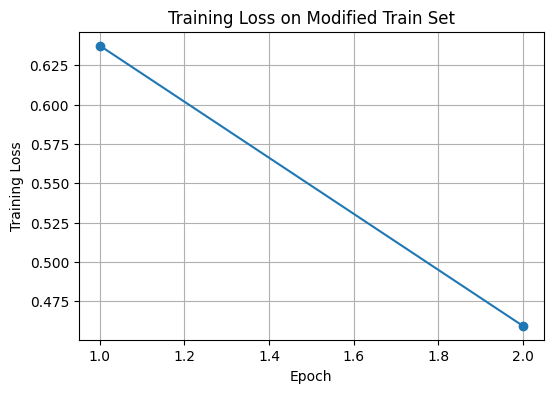

In [30]:
# Plot training loss curve
plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs + 1), train_losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss on Modified Train Set")
plt.grid(True)
plt.show()

In [31]:
def evaluate(model, loader, device):
    """
    Returns:
      y_true: np.array, shape (N,)
      y_pred: np.array, shape (N,)
      mis_idx_dataset: indices within this loader/dataset where y_true != y_pred
      mis_idx_original: corresponding original indices (0..208 in full train_set)
    """
    model.eval()
    all_labels = []
    all_preds = []
    all_orig_indices = []

    with torch.no_grad():
        for images, labels, orig_idx in loader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)

            logits = model(images)
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()

            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_orig_indices.append(orig_idx.numpy())

    y_true = np.vstack(all_labels).ravel()
    y_pred = np.vstack(all_preds).ravel()
    orig_idx_all = np.concatenate(all_orig_indices)

    mis_mask = (y_true != y_pred)
    mis_idx_dataset = np.where(mis_mask)[0]
    mis_idx_original = orig_idx_all[mis_mask]

    return y_true, y_pred, mis_idx_dataset, mis_idx_original


def show_misclassified_images(dataset, mis_idx_dataset, y_pred, num_to_show=4, title_prefix=""):
    """
    Visualize some misclassified examples from a given dataset.
    """
    num_to_show = min(num_to_show, len(mis_idx_dataset))
    if num_to_show == 0:
        print("No misclassified samples to display.")
        return

    # ImageNet normalization stats for unnormalization
    mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    std  = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)

    fig, axes = plt.subplots(1, num_to_show, figsize=(4 * num_to_show, 4))
    if num_to_show == 1:
        axes = [axes]

    for ax, ds_idx in zip(axes, mis_idx_dataset[:num_to_show]):
        img_tensor, label, orig_idx = dataset[ds_idx]

        # Unnormalize image
        img = img_tensor.numpy()
        img = img * std + mean
        img = np.clip(img, 0, 1)
        img = np.transpose(img, (1, 2, 0))  # CHW -> HWC

        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"orig idx: {orig_idx}\ntrue: {int(label)} pred: {int(y_pred[ds_idx])}")

    plt.suptitle(title_prefix + " Misclassified Images")
    plt.show()

In [32]:
def show_misclassified_images(dataset, mis_idx_dataset, y_pred, num_to_show=4, title_prefix=""):
    num_to_show = min(num_to_show, len(mis_idx_dataset))
    if num_to_show == 0:
        print("No misclassified samples to display.")
        return

    mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    std  = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)

    fig, axes = plt.subplots(1, num_to_show, figsize=(4 * num_to_show, 4))
    if num_to_show == 1:
        axes = [axes]

    for ax, ds_idx in zip(axes, mis_idx_dataset[:num_to_show]):
        img_tensor, label, orig_idx = dataset[ds_idx]

        # Unnormalize
        img = img_tensor.numpy()
        img = img * std + mean
        img = np.clip(img, 0, 1)
        img = np.transpose(img, (1, 2, 0))  # CHW -> HWC

        ax.imshow(img)
        ax.axis("off")
        ax.set_title(
            f"orig idx: {orig_idx}\ntrue: {int(label)} pred: {int(y_pred[ds_idx])}",
            fontsize=10
        )

    # Nice, non-overlapping overall title
    fig.suptitle(f"{title_prefix} Misclassified Images", fontsize=14, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

Training accuracy on NEW train set (size 167): 96.41%
Test accuracy on NEW test set (size 42): 92.86%

Classification report on NEW test set:
              precision    recall  f1-score   support

     non-cat       0.97      0.93      0.95        30
         cat       0.85      0.92      0.88        12

    accuracy                           0.93        42
   macro avg       0.91      0.93      0.91        42
weighted avg       0.93      0.93      0.93        42


Misclassified NEW TEST indices (dataset indices 0..N_test-1):
[18 28 39]

Misclassified NEW TEST original indices (0..208 in original train_set):
[185 195 206]


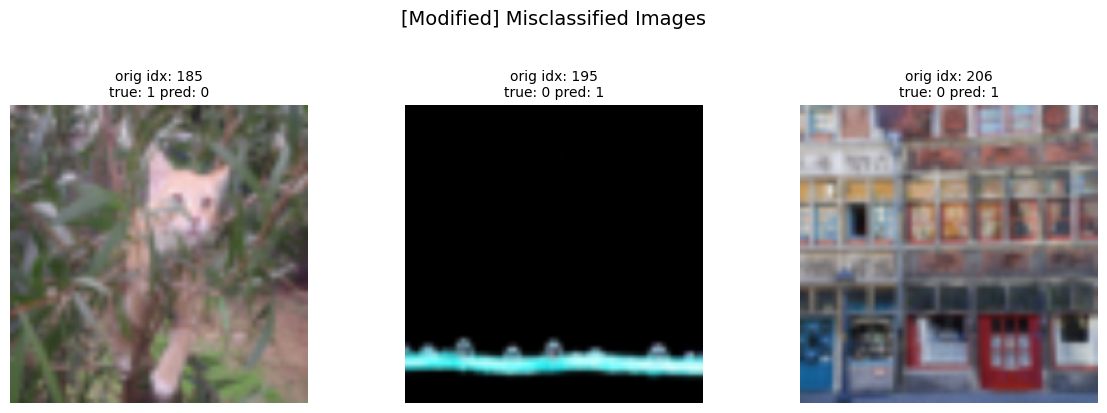

In [33]:
# 1) Accuracy on the NEW training set
y_true_train, y_pred_train, _, _ = evaluate(model, train_loader, device)
train_acc = (y_true_train == y_pred_train).mean()
print(f"Training accuracy on NEW train set (size {len(train_dataset)}): {train_acc * 100:.2f}%")

# 2) Accuracy on the NEW test set
y_true_test, y_pred_test, mis_idx_ds, mis_idx_orig = evaluate(model, test_loader, device)
test_acc = (y_true_test == y_pred_test).mean()
print(f"Test accuracy on NEW test set (size {len(test_dataset)}): {test_acc * 100:.2f}%\n")

print("Classification report on NEW test set:")
print(classification_report(y_true_test, y_pred_test, target_names=["non-cat", "cat"]))

# Requirement 3: print indices of ALL misclassified test images
print("\nMisclassified NEW TEST indices (dataset indices 0..N_test-1):")
print(mis_idx_ds)

print("\nMisclassified NEW TEST original indices (0..208 in original train_set):")
print(mis_idx_orig)

# Requirement 3: display 4 misclassified test examples
show_misclassified_images(
    dataset=test_dataset,
    mis_idx_dataset=mis_idx_ds,
    y_pred=y_pred_test,
    num_to_show=4,
    title_prefix="[Modified]"
)